In [1]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
import numpy.matlib
import scipy.stats as stats 
sns.set_theme() # set the plotting atmosphere

In [2]:
crayons = sns.color_palette("hls", 8)

In [3]:
NumBins = 6
NumChans = 128
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']
cll=['1%', '3%', '5%', '16%', '40%', '100%']
ttl = ['2f1','4f1','6f1','8f1','2f2','4f2','6f2','8f2']
elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
elec_Arc4_inner = [71,67,62,77,76,75,     72]
AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
#AllAnalysisChans = np.concatenate([elec_Arc2,elec_Arc3,elec_Arc4_inner])
AnalysisChans = np.unique(AllAnalysisChans) - 1
VisChans = np.sort(AnalysisChans)
print(f'Channels to be visualized: {VisChans}')
ch_list = np.arange(0,NumChans,1)
ocm = np.zeros_like((ch_list))
ocm[VisChans] = True # set good chans to true
ocm_chans = ocm.astype(bool)

Channels to be visualized: [30 36 41 46 50 51 52 53 54 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97]


In [4]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>


In [5]:
def ConcateAllDataperCo(NumSubs,AttnX_bool,GoodSubjArr,xFxData,xFX_Ind):
    """Concates all subj data into a 4d array
        DictIn = Dict of all data 
        AttnX_bool and GoodSubjArr = binary bools to sort data
        xFx_Ind = keys for all haronic and hemifield data
        Returns::: Dict with 2 keys (attnL and attnR conditions given xFx)"""
    AllData_perSubjCo = {}
    co_temp1 = []
    co_temp2 = []
    for suIn in range(NumSubs):
        if AttnX_bool[suIn] and GoodSubjArr[suIn] == 1:
            co_temp1.append(xFxData[suIn][xFX_Ind])

        if AttnX_bool[suIn] == 0 and GoodSubjArr[suIn] == 1:
            co_temp2.append(xFxData[suIn][xFX_Ind])

    AllData_perSubjCo[0] = np.array(co_temp1) # all attnL data
    AllData_perSubjCo[1] = np.array(co_temp2) # all attnR data
    return AllData_perSubjCo

def CombineData(condInt,DictIn):
    """Average Participants data:pre and post,attnL, attnR,F1,F2"""
    kIn = DictIn[condInt]
    #nSubs = int(kIn[0].shape[0]) # to get error bars
    BinChanAct = {}
    for attnxCo in range(2):
        dIn = np.array(kIn[attnxCo]) # 
        #print(dIn.shape)
        avgtemp = np.zeros((NumBins,2,NumChans))
        for pp in range(2):
            pIn = dIn[:,:,pp,:] # get pre or post data
            avgtemp[:,pp,:] = np.nanmean(pIn[:,pp,:],axis = 0)
        BinChanAct[attnxCo] = avgtemp
    return BinChanAct

def Get_Post_Pre_Inf(dictIn,xfx, attn):
    x = dictIn[xfx][attn] # 4 dims [numubs,numbins,pepo,allchans]
    ns = np.shape(x)[0] # get number of subjets per condition to get error bars for difference in responses
    print(f'numsubs: {ns}')
    # pre-allocate data 
    get_diffs = np.zeros((ns,NumBins,NumChans)) # differnce in response 
    get_sums = np.zeros_like(get_diffs) # sum response per electrodes 
    diff_algor = np.zeros_like(get_diffs) #2*(post-pre/pre+post)
    # find the difference and sum for avg ativity at each electrode 
    for sIn in range(ns):
        dIn  = x[sIn,:,:,:] # enter 1 subs pre and post data [6x2x128]
        get_diffs[sIn,:,:] = (dIn[:,1,:] - dIn[:,0,:]) # post - pre per channel
        get_sums[sIn,:,:] = (dIn[:,1,:] + dIn[:,0,:]) # post - pre per channel

    # compute and fill data with net response differences 
    for s_iters in range(ns):
        diff_algor[s_iters,:,:] = 2*((get_diffs[s_iters,:,:])/(get_sums[s_iters,:,:]))

    # get all net channel induction response activity for topoplots
    diff_mean_topo = np.nanmean(diff_algor,axis = (0)) 
    # get average difference given occipital channels only
    occiMean = np.nanmean(diff_algor[:,:,VisChans], axis = (0,2))
    occistd  = (np.nanstd(diff_algor[:,:,VisChans], axis = (0,2)) / np.sqrt(ns))

    # # plots to see channel activity / sanity check 
    # for b in range(NumBins):
    #     plt.plot(diff_mean_topo[b,:], label = f'{cll[b]}')
    #     plt.legend()
    # plt.show()
    return diff_algor, diff_mean_topo, occiMean, occistd


def init_TopoTemplate(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].gridspec_kw=dict(height_ratios=[3])
    axes[1].gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    #axes[0].set_title(f'{title_In}', fontsize = 20)
    #axes[1].set_title(f'{title_In}', fontsize = 20)
    return fig, axes

def init_TopoTemplate_3Plots(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    axes[0].gridspec_kw=dict(height_ratios=[3])
    axes[1].gridspec_kw=dict(height_ratios=[3])
    axes[2].gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    #axes[0].set_title(f'{title_In}', fontsize = 20)
    #axes[1].set_title(f'{title_In}', fontsize = 20)
    return fig, axes

# def init_TopoTemplate(title_In):
#     """Prep topo plot fig and axes"""
#     fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
#     axes.axis('off')
#     axes.gridspec_kw=dict(height_ratios=[3])
#     plt.tight_layout()
#     axes.set_title(f'{title_In}', fontsize = 20)
#     return fig, axes

In [6]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMat' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {len(dataFileNames)}')
##############################################
FileN = dataFileNames[1]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: 2
Current WD: C:\plimon\LTP_analysis\eegMatFiles\AllMat\AllSubj_MatFiles_C1_20240422_162530.pkl
Does File #1 Exist? True


In [7]:
loadData = pkl.load(open(file_path1, 'rb'))
print(loadData.keys())

dict_keys(['EEGData', 'SubIDs'])


In [8]:
xFxData = loadData['EEGData']
FileNames = loadData['SubIDs']

In [9]:
NumSubs = int(len(FileNames))
print(f'Total Number of Data Files: {NumSubs}')

Total Number of Data Files: 50


In [10]:
str_catch = '-'
SubjID = np.array([file_name.split(str_catch)[1] for file_name in FileNames])
AttnX_Condition = np.array([file_name.split(str_catch)[2] for file_name in FileNames])

In [11]:
UniqueSubjs, SessionsComp = np.unique(SubjID, return_counts = True)
print(f'{int(len(UniqueSubjs))} Total Subjects')
print(f'{np.sum(SessionsComp == 2)} subjects completed both sessions')
print(SubjID) # subject ids 

32 Total Subjects
18 subjects completed both sessions
['2652' '2655' '2657' '2658' '2661' '2661' '2663' '2664' '2665' '2665'
 '2666' '2666' '2667' '2667' '2668' '2668' '2669' '2669' '2670' '2670'
 '2671' '2671' '2672' '2672' '2674' '2674' '2676' '2677' '2677' '2678'
 '2695' '2695' '2696' '2696' '2697' '2697' '2708' '2716' '2726' '2727'
 '2728' '2728' '2733' '2734' '345202' '345202' '345215' '345215' '345216'
 '345216']


#### combine expt regardless of attnx? (no attnl / r separation)

In [12]:
AttnX_bool = np.zeros((NumSubs))
AttnX_bool = [1 if 'attnL' in x else 0 for x in AttnX_Condition]
print(f'Total AttnL files: #{np.sum(AttnX_bool)}')

# to combine attnL and attnR
# arr1 = np.ones((49))
# print(arr1.shape)
# xtra = 0
# AttnX_bool = np.hstack((arr1,xtra))
# print(AttnX_bool.shape)
# AttnX_bool = np.ones((NumSubs))
#print(f'Total AttnL files: #{np.sum(AttnX_bool)}')

Total AttnL files: #26


In [13]:
GoodSubjArr = np.ones(NumSubs)
BadSubs = ['2699']
# BadSubs = ['2663','2734','2652']
GoodSubs_bool = [1 if good_subj and x not in BadSubs else 0 for x, good_subj in zip(SubjID, GoodSubjArr)]
print(np.unique(GoodSubs_bool, return_counts = True))

(array([1]), array([50], dtype=int64))


In [14]:
CleanData = {}
for allConds in range(8):
    CleanData[allConds] = ConcateAllDataperCo(NumSubs, AttnX_bool,GoodSubjArr,xFxData,xFX_Ind = allConds)

In [15]:
DiffData = {}
AvgChanActivity = {}
occi_means = {}
occi_stds = {} 

for allCo in range(8):
    DiffData[allCo] = {}
    AvgChanActivity[allCo] = {}
    occi_means[allCo] = {}
    occi_stds[allCo] = {} 
    for pepo in range(2):
        print (f'Now sorting conditon#: {allCo}, pepo ind#: {pepo}')
        DiffData[allCo][pepo],AvgChanActivity[allCo][pepo],occi_means[allCo][pepo],occi_stds[allCo][pepo]=Get_Post_Pre_Inf(dictIn=CleanData,xfx=allCo,attn=pepo)

Now sorting conditon#: 0, pepo ind#: 0
numsubs: 26
Now sorting conditon#: 0, pepo ind#: 1
numsubs: 24
Now sorting conditon#: 1, pepo ind#: 0
numsubs: 26
Now sorting conditon#: 1, pepo ind#: 1
numsubs: 24
Now sorting conditon#: 2, pepo ind#: 0
numsubs: 26
Now sorting conditon#: 2, pepo ind#: 1
numsubs: 24
Now sorting conditon#: 3, pepo ind#: 0
numsubs: 26
Now sorting conditon#: 3, pepo ind#: 1
numsubs: 24
Now sorting conditon#: 4, pepo ind#: 0
numsubs: 26
Now sorting conditon#: 4, pepo ind#: 1
numsubs: 24
Now sorting conditon#: 5, pepo ind#: 0
numsubs: 26
Now sorting conditon#: 5, pepo ind#: 1
numsubs: 24
Now sorting conditon#: 6, pepo ind#: 0
numsubs: 26
Now sorting conditon#: 6, pepo ind#: 1
numsubs: 24
Now sorting conditon#: 7, pepo ind#: 0
numsubs: 26
Now sorting conditon#: 7, pepo ind#: 1
numsubs: 24


Text(0.5, 0.98, 'Post-Pre Response per Contrast')

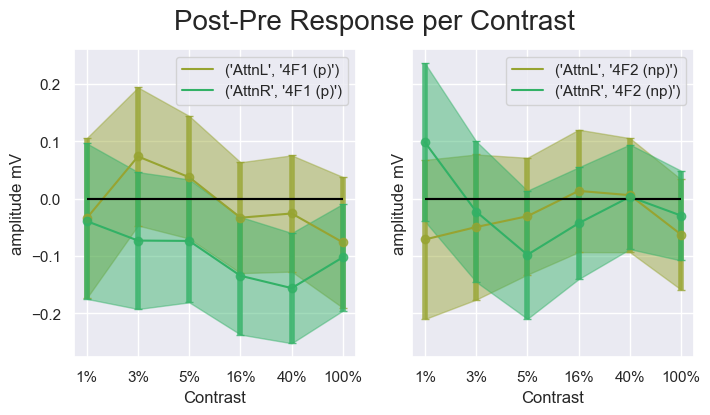

In [73]:
crayons = sns.color_palette("husl", 8)
colabs = ['AttnL', 'AttnR']
freqlabs = ['4F1 (p)', '4F2 (np)']

fx_diffs = [occi_means[1], occi_means[5]]
fx_stds = [occi_stds[1], occi_stds[5]]

attnInd = 0

fig,axs = plt.subplots(1,2,figsize = (8,4), sharey = True)

for HemiCo in range(2): # f1 and then f2
    for attnCo in range(2): # attnL and attnR
        #print(f'{colabs[HemiCo], freqlabs[attnCo]}') #plot Fx attnL/R then move to other hemidata
        xIn = fx_diffs[HemiCo][attnCo]
        x_stds = fx_stds[HemiCo][attnCo]
        axs[attnCo].plot(xIn, label = f'{colabs[HemiCo], freqlabs[attnCo]}', color = crayons[HemiCo+2])
        axs[attnCo].errorbar((np.arange(NumBins)),xIn,x_stds,fmt = 'o', linewidth = 3, elinewidth = 4, capsize = 3, alpha = 0.8,color = crayons[HemiCo+2])
        axs[attnCo].fill_between(np.arange(NumBins), xIn-x_stds,xIn+x_stds,color = crayons[HemiCo+2], alpha=0.45)
        axs[attnCo].legend()
        axs[attnCo].hlines(0,xmin = 0,xmax = 5, color = 'black')
        #axs[attnCo].set_title(f'{freqlabs[0]} {colabs[attnCo]}',fontsize = 20)
        axs[attnCo].set_xticks(range(len(contrast_levels_labs)))
        axs[attnCo].set_xticklabels(contrast_levels_labs)
        axs[attnCo].set_xlabel(f'Contrast')
        axs[attnCo].set_ylabel(f'amplitude mV')
plt.suptitle(f'Post-Pre Response per Contrast', fontsize = 20)

In [74]:
AvgChanPerBinAct = {}
for i in range(8):
    AvgChanPerBinAct[i]=CombineData(condInt = i,DictIn = CleanData)

In [75]:
test = CleanData[0][0]
print(test.shape)

pre_avg = np.nanmean(test[:,:,0,VisChans], axis = (0)) # bins x chand
post_avg = np.nanmean(test[:,:,1,VisChans], axis = (0))


(26, 6, 2, 128)


In [76]:
# for bin in range(NumBins):
#     fig,axs = plt.subplots(figsize = (3,3))
#     axs.plot(pre_avg[bin,:], label = f'pre contrast {bin}')
#     axs.plot(post_avg[bin,:], label = f'post contrast {bin}')
#     axs.legend(loc = 'upper left', fontsize = 5)

In [77]:
SecHarmData[0].keys()

dict_keys([0, 1])

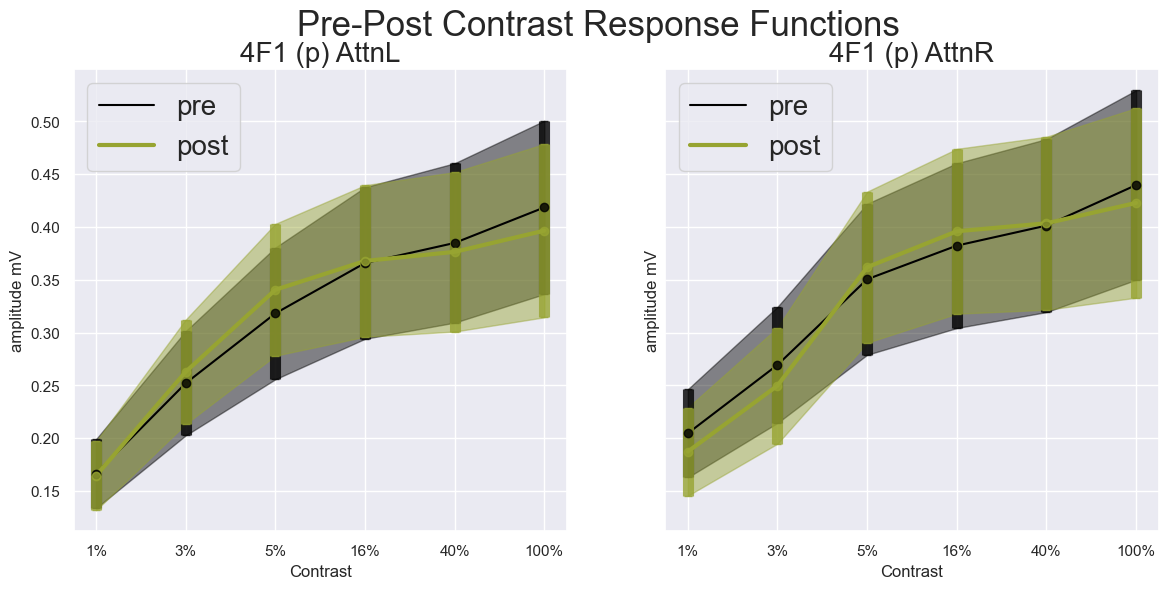

In [78]:
# colabs = ['AttnL', 'AttnR']
# freqlabs = ['2F1 (p)', '2F2 (np)']

SecHarmData = [CleanData[1], CleanData[1]] # 2F1 [attnl/r] , 2F2 [atnl/r]


fig,axs = plt.subplots(1,2,figsize = ((14,6)), sharey = True)
for attnX_iter in range(2):
    xIn = SecHarmData[0][attnX_iter] # 2F1

    ns = np.sqrt(np.shape(xIn)[0])
    t_mean_pre = np.nanmean(xIn[:,:,0,ocm == 1],axis  = 0) # contrasts[6] x channels 
    t_mean_post = np.nanmean(xIn[:,:,1,ocm == 1],axis  = 0) # contrasts[6] x channels 

    crf_pre = np.nanmean(t_mean_pre, axis = 1)
    pre_std = np.nanmean(t_mean_pre, axis = 1) / ns
    crf_post = np.nanmean(t_mean_post, axis = 1)
    post_std = np.nanmean(t_mean_pre, axis = 1) / ns


    axs[attnX_iter].plot(crf_pre, label = 'pre', color = 'black')
    axs[attnX_iter].errorbar((np.arange(NumBins)),crf_pre,pre_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8,color = 'black')
    axs[attnX_iter].fill_between(np.arange(NumBins), crf_pre-pre_std,crf_pre+pre_std, color = 'black', alpha=0.45)

    axs[attnX_iter].plot(crf_post, label = 'post', color = crayons[2], linewidth = 3)
    axs[attnX_iter].errorbar((np.arange(NumBins)),crf_post,post_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8,color = crayons[2])
    axs[attnX_iter].fill_between(np.arange(NumBins), crf_post-post_std,crf_post+post_std, color = crayons[2], alpha=0.45)

    axs[attnX_iter].set_title(f'{freqlabs[0]} {colabs[attnX_iter]}',fontsize = 20)
    axs[attnX_iter].set_xticks(range(len(contrast_levels_labs)))
    axs[attnX_iter].set_xticklabels(contrast_levels_labs)
    axs[attnX_iter].set_xlabel(f'Contrast')
    axs[attnX_iter].set_ylabel(f'amplitude mV')
    axs[attnX_iter].legend(fontsize = 20)

    plt.suptitle(f'Pre-Post Contrast Response Functions', fontsize = 25)


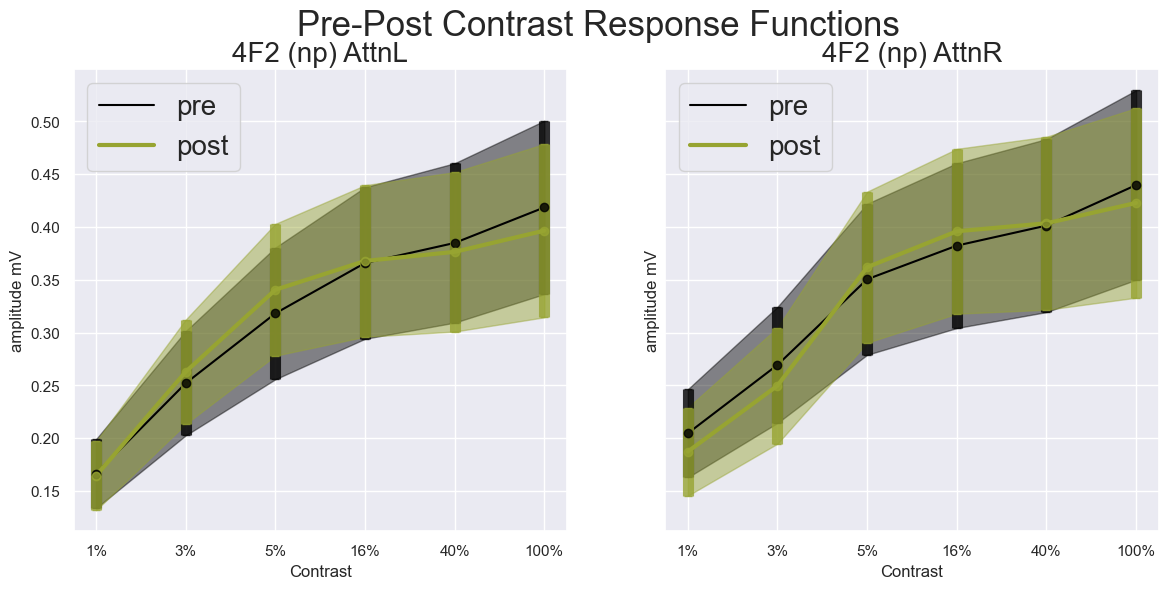

In [79]:
fig,axs = plt.subplots(1,2,figsize = ((14,6)), sharey = True)
for attnX_iter in range(2):
    xIn = SecHarmData[1][attnX_iter] # 2F1
    ns = np.sqrt(np.shape(xIn)[0])
    t_mean_pre = np.nanmean(xIn[:,:,0,ocm == 1],axis  = 0) # contrasts[6] x channels 
    t_mean_post = np.nanmean(xIn[:,:,1,ocm == 1],axis  = 0) # contrasts[6] x channels 

    crf_pre = np.nanmean(t_mean_pre, axis = 1)
    pre_std = np.nanmean(t_mean_pre, axis = 1) / ns
    crf_post = np.nanmean(t_mean_post, axis = 1)
    post_std = np.nanmean(t_mean_pre, axis = 1) / ns


    axs[attnX_iter].plot(crf_pre, label = 'pre', color = 'black')
    axs[attnX_iter].errorbar((np.arange(NumBins)),crf_pre,pre_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8,color = 'black')
    axs[attnX_iter].fill_between(np.arange(NumBins), crf_pre-pre_std,crf_pre+pre_std, color = 'black', alpha=0.45)

    axs[attnX_iter].plot(crf_post, label = 'post', color = crayons[2], linewidth = 3)
    axs[attnX_iter].errorbar((np.arange(NumBins)),crf_post,post_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8,color = crayons[2])
    axs[attnX_iter].fill_between(np.arange(NumBins), crf_post-post_std,crf_post+post_std, color = crayons[2], alpha=0.45)

    axs[attnX_iter].set_title(f'{freqlabs[1]} {colabs[attnX_iter]}', fontsize = 20)
    axs[attnX_iter].set_xticks(range(len(contrast_levels_labs)))
    axs[attnX_iter].set_xticklabels(contrast_levels_labs)
    axs[attnX_iter].set_xlabel(f'Contrast')
    axs[attnX_iter].set_ylabel(f'amplitude mV')
    axs[attnX_iter].legend(fontsize = 20)

    plt.suptitle(f'Pre-Post Contrast Response Functions', fontsize = 25)


#### get response differnces and plot them on top of eah other - based on the 2*ppost-pre/pre+post

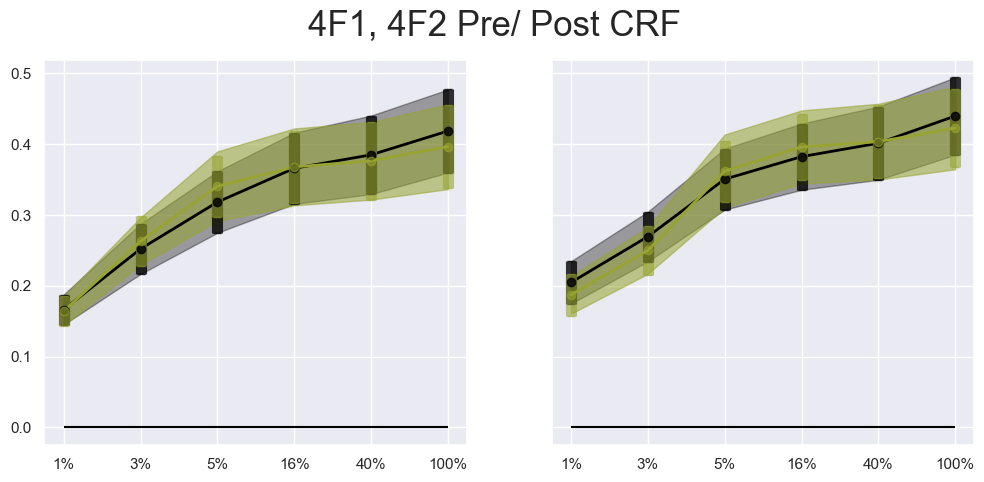

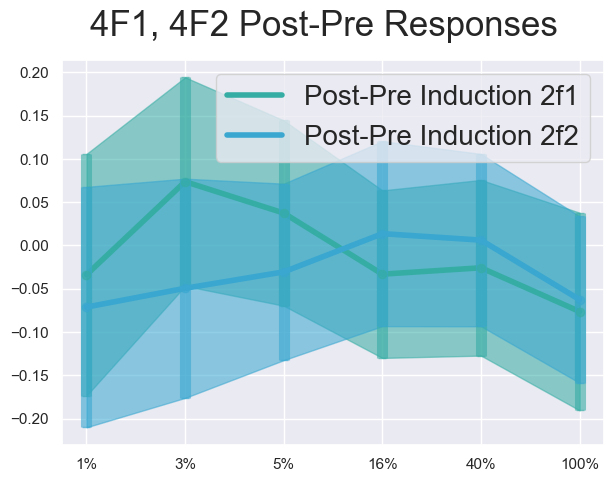

In [82]:

fig,axs = plt.subplots(1,2,figsize = ((12,5)), sharey = True, sharex = True)
plt.suptitle(f'4F1, 4F2 Pre/ Post CRF', fontsize = 25)

diff_fig,diff_axs = plt.subplots(1,figsize = ((7,5)), sharey = True, sharex = True)
plt.suptitle(f'4F1, 4F2 Post-Pre Responses', fontsize = 25)

for c in range(2):

    dsIn = np.array(SecHarmData[0][c])

    ns = np.sqrt(np.shape(dsIn)[0])
    ## import pre and post
    pre_avg = dsIn[:,:,0,ocm ==1]
    post_avg =  dsIn[:,:,1,ocm == 1]
    ## average 
    pre_m1 = np.nanmean(pre_avg,axis = (0,2))
    post_m1 = np.nanmean(post_avg,axis = (0,2))
    ## get stds
    pre_std = np.nanstd(pre_avg,axis = (0,2)) / ns
    post_std = np.nanstd(post_avg,axis = (0,2)) / ns
    ### caculate mean difference in activity
    diff_act = (post_avg - pre_avg)
    sum_act = (post_avg + pre_avg)

    diff_resp = 2*((diff_act)/(sum_act))
    #diff_resp = diff_act  / pre_avg

    diff_avg = np.nanmean(diff_resp,axis = (0,2))
    diff_std = np.nanstd(diff_resp,axis = (0,2)) / ns

    # plot pre data!!
    axs[c].plot(pre_m1, label = 'Pre Induction', color = 'black', linewidth = 2)
    axs[c].errorbar((np.arange(NumBins)),pre_m1,pre_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8,color = 'black')
    axs[c].fill_between(np.arange(NumBins), pre_m1-pre_std,pre_m1+pre_std, color = 'black', alpha=0.35)

    ## plot post data!!
    axs[c].plot(post_m1, label = 'Post Induction', color = crayons[2], linewidth = 2)
    axs[c].errorbar((np.arange(NumBins)),post_m1,pre_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.6,color = crayons[2])
    axs[c].fill_between(np.arange(NumBins), post_m1-post_std,post_m1+post_std, color = crayons[2], alpha=0.55)

    axs[c].hlines(0,xmin = 0,xmax = 5, color = 'black')
    axs[c].set_xticks(range(len(contrast_levels_labs)))
    axs[c].set_xticklabels(contrast_levels_labs)
    #axs[0].legend(fontsize = 20)


    diff_axs.plot(diff_avg, label = f'Post-Pre Induction 2f{c+1}', color = crayons[4+c], linewidth = 4)
    diff_axs.errorbar((np.arange(NumBins)),diff_avg,diff_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.6,color = crayons[4+c])
    diff_axs.fill_between(np.arange(NumBins), diff_avg-diff_std,diff_avg+diff_std, color = crayons[4+c], alpha=0.55)
    diff_axs.set_xticks(range(len(contrast_levels_labs)))
    diff_axs.set_xticklabels(contrast_levels_labs)
    #diff_axs.hlines(0,xmin = 0,xmax = 5, color = 'black', label = 'No Change')
    diff_axs.legend(fontsize = 20)

#### Perform some pre-post t-tests on data

#### plot some topos of data

In [ ]:
colabs = ['AttnL', 'AttnR']
freqlabs = ['2F1', '2F2']

SecHarmData = [CleanData[0], CleanData[4]]

for topo_runs in range(2):
    xIn = SecHarmData[0] # 2F1
    coIn = xIn[topo_runs] # attnL / attnR
    t_mean_pre = np.nanmean(coIn[:,:,0,:],axis  = 0) # contrasts[6] x channels 
    t_mean_post = np.nanmean(coIn[:,:,1,:],axis  = 0) # contrasts[6] x channels 

    for j in range(NumBins):
        fig, axes = init_TopoTemplate_3Plots(f'2F1 {colabs[topo_runs]}, Pre/Post/Net activity post induction {cll[j]} contrast')

        #fig, axes = init_TopoTemplate_3Plots(f'2F2 attnR, Pre/Post/Net activity post induction {cll[j]} contrast')
        dIn_pe = t_mean_pre[j,:] # enter 1 contrast data per iteration
        dIn_po = t_mean_post[j,:] # enter 1 contrast data per iteration
        # import differences 
        #diff_res = diff_inResponse[j,:]
        # or do it in real time for now
        totdiff = dIn_po - dIn_pe
        totsum = dIn_po + dIn_pe
        # options 
        #diffIn = 2* (totdiff / totsum) # 128 # original diff method
        diffIn = (totdiff / dIn_pe) # new diff method

        # dIn_pe[ocm == 0] = 0
        # dIn_po[ocm == 0] = 0 
        # diff_res[ocm == 0] = 0
        diffIn[ocm == 0] = 0
        #print(np.min(diffIn),np.max(diffIn))
        pp_vmax = 1.3
        pp_vmin = 0
        dd_vmax = 0.25#0.5
        dd_vmin = -0.3
        
        # left side plot
        im,_ = plot_topomap(dIn_pe, info,mask = ocm,vlim = [pp_vmin,pp_vmax], axes = axes[0],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        # middle  plot
        im,_ = plot_topomap(dIn_po, info,mask = ocm,vlim = [pp_vmin,pp_vmax], axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        # final plot
        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes('left', size='5%', pad=0.1)
        cbar = plt.colorbar(im, cax=cax)

        #vlim = [dd_vmin,dd_vmax]
        im,_ = plot_topomap(diffIn, info,mask = ocm, vlim = [dd_vmin,dd_vmax],axes = axes[2],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        #im,_ = plot_topomap(diffIn, info,mask = ocm, axes = axes[2],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        #axes[1].set_title(f'attnL 2F1 pre / post')

        divider_diff = make_axes_locatable(axes[2])
        cax_diff = divider_diff.append_axes('left', size='5%', pad=0.1)
        cbar = plt.colorbar(im, cax=cax_diff)


In [ ]:
for topo_runs in range(2):
    xIn = SecHarmData[1] # 2F2
    coIn = xIn[topo_runs] # attnL / attnR
    t_mean_pre = np.nanmean(coIn[:,:,0,:,],axis  = 0) # contrasts[6] x channels 
    t_mean_post = np.nanmean(coIn[:,:,1,:,],axis  = 0) # contrasts[6] x channels 

    for j in range(NumBins):
        fig, axes = init_TopoTemplate_3Plots(f'2F2 {colabs[topo_runs]}, Pre/Post/Net activity post induction {cll[j]} contrast')

        #fig, axes = init_TopoTemplate_3Plots(f'2F2 attnR, Pre/Post/Net activity post induction {cll[j]} contrast')
        dIn_pe = t_mean_pre[j,:] # enter 1 contrast data per iteration
        dIn_po = t_mean_post[j,:] # enter 1 contrast data per iteration
        # import differences 
        #diff_res = diff_inResponse[j,:]
        # or do it in real time for now
        totdiff = dIn_po - dIn_pe
        totsum = dIn_po + dIn_pe
        # options 
        #diffIn = 2* (totdiff / totsum) # 128 # original diff method
        diffIn = (totdiff / dIn_pe) # new diff method

        # dIn_pe[ocm == 0] = 0
        # dIn_po[ocm == 0] = 0 
        # diff_res[ocm == 0] = 0
        diffIn[ocm == 0] = 0
        #print(np.min(diffIn),np.max(diffIn))
        pp_vmax = 1.3
        pp_vmin = 0
        dd_vmax = 0.25#0.5
        dd_vmin = -0.3
        
        # left side plot
        im,_ = plot_topomap(dIn_pe, info,mask = ocm,vlim = [pp_vmin,pp_vmax], axes = axes[0],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        # middle  plot
        im,_ = plot_topomap(dIn_po, info,mask = ocm,vlim = [pp_vmin,pp_vmax], axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        # final plot
        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes('left', size='5%', pad=0.1)
        cbar = plt.colorbar(im, cax=cax)

        #vlim = [dd_vmin,dd_vmax]
        im,_ = plot_topomap(diffIn, info,mask = ocm, vlim = [dd_vmin,dd_vmax],axes = axes[2],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        #im,_ = plot_topomap(diffIn, info,mask = ocm, axes = axes[2],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
        #axes[1].set_title(f'attnL 2F1 pre / post')

        divider_diff = make_axes_locatable(axes[2])
        cax_diff = divider_diff.append_axes('left', size='5%', pad=0.1)
        cbar = plt.colorbar(im, cax=cax_diff)

In [ ]:
# print(CleanData[0][0].shape) # 
# # print(ocm == 1)

sx = CleanData[0][0] # pre data attnL, pre , 26 x 6 x [pre/post] x channels
diff_inResponse = AvgChanActivity[0][0]


NumSubs = sx.shape[0] # number of subjects

##############
t_mean_pre = np.nanmean(sx[:,:,0,:,],axis  = 0) # contrasts[6] x channels 
t_mean_post = np.nanmean(sx[:,:,1,:,],axis  = 0) # contrasts[6] x channels 


for j in range(NumBins):
    fig, axes = init_TopoTemplate_3Plots(f'2F2 attnR, Pre/Post/Net activity post induction {cll[j]} contrast')

    dIn_pe = t_mean_pre[j,:] # enter 1 contrast data per iteration
    dIn_po = t_mean_post[j,:] # enter 1 contrast data per iteration
    diff_res = diff_inResponse[j,:]

    totdiff = dIn_po - dIn_pe
    totsum = dIn_po + dIn_pe
    #diffIn = 2* (totdiff / totsum) # 128 
    diffIn = (totdiff / dIn_pe)


    # dIn_pe[ocm == 0] = 0
    # dIn_po[ocm == 0] = 0 
    # diff_res[ocm == 0] = 0
    #diffIn[ocm == 0] = 0

    # print(np.max(diffIn))
    # print(np.min(diffIn))

    pp_vmax = 1.3
    pp_vmin = 0

    dd_vmax = 0.5
    dd_vmin = -0.3
    
    # left side plot
    im,_ = plot_topomap(dIn_pe, info,mask = ocm,vlim = [pp_vmin,pp_vmax], axes = axes[0],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(dIn_po, info,mask = ocm,vlim = [pp_vmin,pp_vmax], axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # final plot

    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('left', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

    im,_ = plot_topomap(diffIn, info,mask = ocm,vlim = [dd_vmin,dd_vmax], axes = axes[2],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    #im,_ = plot_topomap(diffIn, info,mask = ocm, axes = axes[2],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    #axes[1].set_title(f'attnL 2F1 pre / post')

    divider_diff = make_axes_locatable(axes[2])
    cax_diff = divider_diff.append_axes('left', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax_diff)

In [ ]:
# print(CleanData[0][0].shape) # 
# # print(ocm == 1)

sx = CleanData[4][1] # pre data attnL, pre , 26 x 6 x [pre/post] x channels
diff_inResponse = AvgChanActivity[4][1]


NumSubs = sx.shape[0] # number of subjects

##############
t_mean_pre = np.nanmean(sx[:,:,0,:,],axis  = 0) # contrasts[6] x channels 
t_mean_post = np.nanmean(sx[:,:,1,:,],axis  = 0) # contrasts[6] x channels 


for j in range(NumBins):
    fig, axes = init_TopoTemplate_3Plots(f'2F2 attnR, Pre/Post/Net activity post induction {cll[j]} contrast')

    dIn_pe = t_mean_pre[j,:] # enter 1 contrast data per iteration
    dIn_po = t_mean_post[j,:] # enter 1 contrast data per iteration
    diff_res = diff_inResponse[j,:]

    totdiff = dIn_po - dIn_pe
    totsum = dIn_po + dIn_pe
    #diffIn = 2* (totdiff / totsum) # 128 
    diffIn = (totdiff / dIn_pe)


    # dIn_pe[ocm == 0] = 0
    # dIn_po[ocm == 0] = 0 
    # diff_res[ocm == 0] = 0
    #diffIn[ocm == 0] = 0

    # print(np.max(diffIn))
    # print(np.min(diffIn))

    pp_vmax = 1.3
    pp_vmin = 0

    dd_vmax = 0.5
    dd_vmin = -0.3
    
    # left side plot
    im,_ = plot_topomap(dIn_pe, info,mask = ocm,vlim = [pp_vmin,pp_vmax], axes = axes[0],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(dIn_po, info,mask = ocm,vlim = [pp_vmin,pp_vmax], axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # final plot

    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('left', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

    im,_ = plot_topomap(diffIn, info,mask = ocm,vlim = [dd_vmin,dd_vmax], axes = axes[2],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    #im,_ = plot_topomap(diffIn, info,mask = ocm, axes = axes[2],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    #axes[1].set_title(f'attnL 2F1 pre / post')

    divider_diff = make_axes_locatable(axes[2])
    cax_diff = divider_diff.append_axes('left', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax_diff)

# # plot to visual average contrast response function per particpant in occipital channels
# crf_vis = np.nanmean(sx[:,:,0,VisChans], axis = (2) ) # 6 x 49 [crf per particpant]
# for ns in range(NumSubs):
#     plt.plot(crf_vis[ns,:])
#     plt.title(f'CRF per particpant (occipital channels)')
#     plt.xlabel(f'contrast levels')
#     plt.ylabel(f' amplitude (mV)')
# plt.show()

In [ ]:
# for o in range(8):
#     obs = o
#     attnL1f1 = CleanData[obs][0]
#     xt_pre_l = np.nanmean(attnL1f1[:,:,0,VisChans],axis =(0,2))
#     xt_post_l = np.nanmean(attnL1f1[:,:,1,VisChans],axis =(0,2))

#     attnR1f1 = CleanData[obs][1]
#     xt_pre_r = np.nanmean(attnR1f1[:,:,0,VisChans],axis = (0,2))
#     xt_post_r = np.nanmean(attnR1f1[:,:,1,VisChans],axis =(0,2))

#     fig,axes=plt.subplots(1,3,figsize=((12,4)),sharey=False)
#     axes[0].plot(xt_pre_l, label = 'pre l')
#     axes[0].plot(xt_post_l, label = 'post l')
#     axes[0].legend()

#     axes[1].plot(xt_pre_r, label = 'pre r')
#     axes[1].plot(xt_post_r, label = 'post r')
#     axes[1].legend()

#     axes[2].plot(xt_pre_l, label = 'pre 1')
#     axes[2].plot(xt_post_l, label = 'post l')
#     axes[2].plot(xt_pre_r, label = 'pre r')
#     axes[2].plot(xt_post_r, label = 'post r')
#     axes[2].legend()

#### use for: *occi_means* and *occi_stds*. Plot F1 and F2 harmonic data

In [ ]:
fig,axs = plt.subplots(figsize = (8,5), sharey = 10)

f1Ind = 0
f2Ind = 4

co_lab = ['L','R']
for pp in range(2):
    axs.plot(occi_means[f1Ind][pp],label = f'F1 attn{co_lab[pp]}',linewidth = 3,color = crayons[2+pp])
    axs.plot(occi_means[f2Ind][pp],label = f'F2 attn{co_lab[pp]}',linewidth = 3,color = crayons[6+pp])
    #axs.errorbar((np.arange(NumBins)),occi_means[f1Ind][pp],occi_stds[f1Ind][pp],fmt = 'o', linewidth = 3, elinewidth = 5, capsize = 3, alpha = 0.6,color = crayons[2+pp])
    #axs.errorbar((np.arange(NumBins)),occi_means[f2Ind][pp],occi_stds[f2Ind][pp],fmt = 'o', linewidth = 3, elinewidth = 5, capsize = 3, alpha = 0.6,color = crayons[6+pp])
    axs.legend(fontsize = 10, loc = 'lower right')

    axs.hlines(0, xmin = 5, xmax = 0, color = 'black', linewidth = 2, label = 'No Change')
    #axs[0].hlines(0, xmin = 5, xmax = 0, color = 'black', linewidth = 2, label = 'No Change')
    axs.set_xticks(range(len(contrast_levels_labs)))
    axs.set_xticklabels(contrast_levels_labs)
    axs.set_xlabel(f'Contrast')
    axs.set_ylabel(f'amplitude mV')
plt.suptitle(f'Response Activity')

#### use for: *AvgChanActivity*  Plot F1 and F2 topo data

In [ ]:
print(CleanData.keys())
print(CleanData[0].keys())
print(CleanData[0][0].shape)
print(CleanData[0][1].shape)

In [ ]:
AllChanAct = {} # data for topos!

for o in range(8): # 8
    # data in 
    keyIn = CleanData[o] # enter key daya that contains attnL and attnR for xFx, pre / post 

    fig,axs = plt.subplots(1,2,figsize = ((8,4)), sharey = True)
    pl = ['pre', 'post']

    AllChanAct[o] = {}
    for attnX in range(2): # iterate for attnL and attnR

        topodata_store = np.zeros((2,NumBins,NumChans)) # empty array to save pre post data topographies
        #print(f'Now imorting attnx key #{attnX}')
        attnDataIn = keyIn[attnX]
        ns = np.shape(attnDataIn)[0] # number of particpants

        for pepo in range(2): # iterate pre and post data arrays
            #print(f'now averaging pre/post # : {pepo}') # iterate for pre and post
            pepoDataIn = attnDataIn[:,:,pepo,:]
            ChanActperBin_topo = np.nanmean(pepoDataIn,axis = 0)  # data for topograph [6 x 128]
            topodata_store[pepo,:,:] = ChanActperBin_topo
            AllChanAct[o][pepo] = topodata_store
            # # calculate stats for occipital channels only
            occiMean = np.nanmean(pepoDataIn[:,:,VisChans], axis = (0,2))
            occistd  = (np.nanstd(pepoDataIn[:,:,VisChans], axis = (0,2)) / np.sqrt(ns))
            if attnX == 0:
                axs[0].plot(occiMean, color = crayons[pepo+6], label = f'{pl[pepo]}')
                axs[0].errorbar((np.arange(NumBins)),occiMean,occistd,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8,color = crayons[pepo+6])
                axs[0].fill_between(np.arange(NumBins), occiMean-occistd,occiMean+occistd, color = crayons[pepo+6], alpha=0.45)
                axs[0].set_xticks(range(len(contrast_levels_labs)))
                axs[0].set_xticklabels(contrast_levels_labs)
                axs[0].legend()
            else:
                axs[1].plot(occiMean, color = crayons[pepo+6],label = f'{pl[pepo]}')
                axs[1].errorbar((np.arange(NumBins)),occiMean,occistd,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8,color = crayons[pepo+6])
                axs[1].fill_between(np.arange(NumBins), occiMean-occistd,occiMean+occistd, color = crayons[pepo+6], alpha=0.45)
                axs[1].set_xticks(range(len(contrast_levels_labs)))
                axs[1].set_xticklabels(contrast_levels_labs)
                axs[1].legend()

In [ ]:
fig,axs=plt.subplots(figsize = (8,3))
for bi in range(NumBins):
    axs.scatter(ch_list,ChanActperBin_topo[bi,:], label = f'c: {cll[bi]}')
    axs.legend()

In [ ]:
AllData_perSubjCo = {}
co_temp1 = []
co_temp2 = []
xFX_Ind = 0 # 0-3 attnL 2f - 8f, 3:7
for suIn in range(NumSubs):
    if AttnX_bool[suIn] and GoodSubjArr[suIn] == 1:
        co_temp1.append(xFxData[suIn][xFX_Ind])

    if AttnX_bool[suIn] == 0 and GoodSubjArr[suIn] == 1:
        co_temp2.append(xFxData[suIn][xFX_Ind])

AllData_perSubjCo[0] = np.array(co_temp1) # all attnL data
AllData_perSubjCo[1] = np.array(co_temp2) # all attnR data

In [ ]:
# pIn = pre_post_avg[1,0,:]
# fig, axes = init_TopoTemplate('AttnR Bin %1')
# im,_ = plot_topomap(pIn, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32,contours =3,outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.4)
# cbar = plt.colorbar(im, cax=cax)
# plt.show()


In [ ]:
# pIn = pre_post_avg[0,1,:]
# fig, axes = init_TopoTemplate('AttnL Bin %1')
# im,_ = plot_topomap(pIn, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32,contours =3,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.4)
# cbar = plt.colorbar(im, cax=cax)
# plt.show()

In [ ]:
# plt.scatter(ch_list,pre_post_avg[0,0,:], label = '1% pre')
# plt.scatter(ch_list,pre_post_avg[0,1,:], label =  '1% post')
# plt.legend()